<h2>Data Analytics- notebook, housing example</h2>

**NOTE:** All AI usage rules etc. apply to data analytics notebooks too. Always mention if generative AI has been used, and how you can be sure the solution is correct!

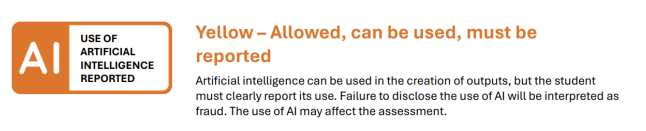

<h4><b>Dataset name / short description:</b></h4>

Seattle Housing Sales data

<h4><b>Data source (url):</b></h4>

https://www.kaggle.com/datasets/astronautelvis/kc-house-data

<h4><b>Data format:</b></h4>

Single csv-file

<h4><b>Data description, features and limitations:</b></h4>

Dataset contains housing data from time period May 2014 - May 2015. Approximately 21000-22000 buildings in total. Each building has information about square footage, view quality, waterfront presence, amount of bedrooms, bathrooms and the condition + grade.

<h3><b>Code: importing modules, custom functions and loading the data</b></h3>

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# load the data
df = pd.read_csv("houses.csv")

# custom function that simplifies the different built years into age categories
# for easier analysis, clearer trends and more simple visualizations
def create_age_group(row):
    year = row['yr_built']

    if year >= 2005:
        return 4
    elif 1985 <= year < 2005:
        return 3
    elif 1960 <= year < 1985:
        return 2
    else:
        return 1
    
# apply the function above
df['age_group'] = df.apply(create_age_group, axis=1)

<h3><b>Code: Data clean-up procedure</b></h3>

Use separate markdown cells if you wish to emphasize an important point or additional information for the reader (see vehicle example)

In [ ]:
# remove location -variables + id (not usable directly)
# also drop date (not much correlation between the years)
df = df.drop(['id', 'lat', 'long', 'zipcode'], axis=1)
df = df.drop("date", axis=1)

# we need to find out => how to convert square footage into square meters
df['living_m2'] = df['sqft_living'] * 0.09290304
df['basement_m2'] = df['sqft_basement'] * 0.09290304
df['lot_m2'] = df['sqft_lot'] * 0.09290304
df['above_m2'] = df['sqft_above'] * 0.09290304
df['living_m2_area'] = df['sqft_living15'] * 0.09290304
df['lot_m2_area'] = df['sqft_lot15'] * 0.09290304

# finally drop the originals
df = df.drop(['sqft_lot', 'sqft_living', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15'], axis=1)

# we could attempt fixing yr_renovated with this logic:
# if there is a real renovation year => keep it as it is
# if renovation year is 0 => use yr_built as the renovation year
# basically measures when was the last time any building effort was done
# but then again, most likely 0 means data is missing in more than 95% of the cases
# => probably just better just to remove this variable (because it's noise)
df = df.drop(['yr_renovated'], axis=1)

# because we have so many variables, we'll remove some of the similar variables
# regarding the areas of the house etc.
df = df.drop(["basement_m2", "lot_m2", "above_m2", "living_m2_area", "lot_m2_area"], axis=1)

# due to high imbalance in waterfront and view, it's possible these variables
# don't affect the result that much (correlations, plots)
# HOWEVER, always double-check with other plots
# for balance and whether there is any significant connection
# by default (by using common sense), only a few houses can be next to water 
# or along a river (because not enough space)

# also dropping condition, since it affects technically nothing
df = df.drop(["view", "waterfront", "condition", "yr_built"], axis=1)

In [37]:
# finally, remove outliers based on normal distribution, everything has to be numeric before using this 
# always remember, this is a quick and dirty way to remove extreme outliers
# however, it's also very straight-forward, and you don't have control what is removed
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

<h3><b>Code: Data analysis</b></h3>

Use separate markdown cells if you wish to emphasize an important point or additional information for the reader (see vehicle example)

In [38]:
# after clean ups, all houses are bettween 78k$ - 1.64 million USD -range
df.describe().astype(int)

,price,bedrooms,bathrooms,floors,grade,age_group,living_m2
count,20899,20899,20899,20899,20899,20899,20899
mean,500986,3,2,1,7,2,186
std,251028,0,0,0,1,1,72
min,78000,1,0,1,5,1,34
25%,319900,3,1,1,7,1,130
50%,445000,3,2,1,7,2,174
75%,623000,4,2,2,8,3,230
max,1640000,6,4,3,11,4,445


In [39]:
# quickly see what kind of data we have
df.head()

,price,bedrooms,bathrooms,floors,grade,age_group,living_m2
0,221900.0,3,1.00,1.0,7,1,109.625587
1,538000.0,3,2.25,2.0,7,1,238.760813
2,180000.0,2,1.00,1.0,6,1,71.535341
3,604000.0,4,3.00,1.0,7,2,182.089958
4,510000.0,3,2.00,1.0,8,3,156.077107


<Axes: >

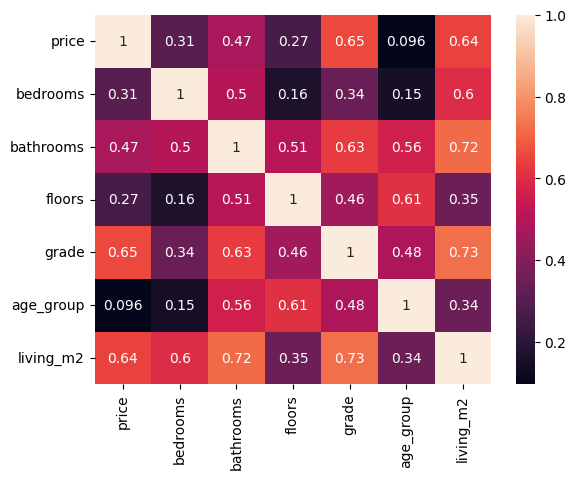

In [40]:
# based on correlations, bathrooms, grade and living area affect the most towards price
correlations = df.corr(numeric_only=True)
sns.heatmap(correlations, annot=True)

<Axes: xlabel='price', ylabel='Count'>

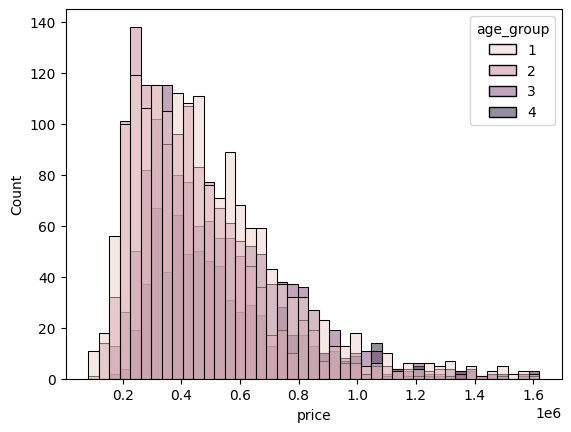

In [41]:
# the age of the building doesn't affect the price directly ...
# but if compared to the correlations above, age affects all other variables
# that instead affect the price directly (indirect support variable)
df_sample = df.sample(5000)

# let's study house age vs price
sns.histplot(x="price", hue="age_group", data=df_sample)

<Axes: xlabel='living_m2', ylabel='price'>

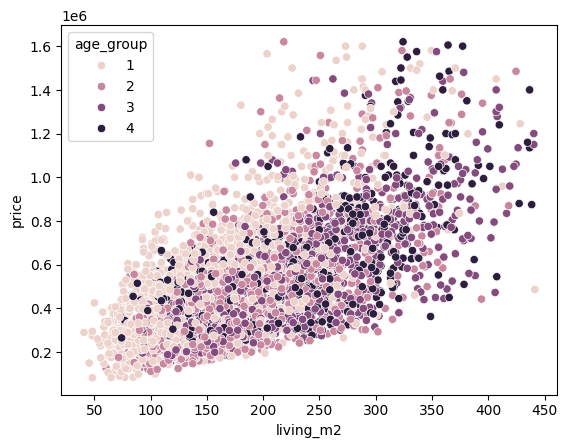

In [42]:
# slight trend, newer houses seem to be somewhat bigger
sns.scatterplot(x="living_m2", y="price", hue="age_group", data=df_sample)

<Axes: xlabel='living_m2', ylabel='price'>

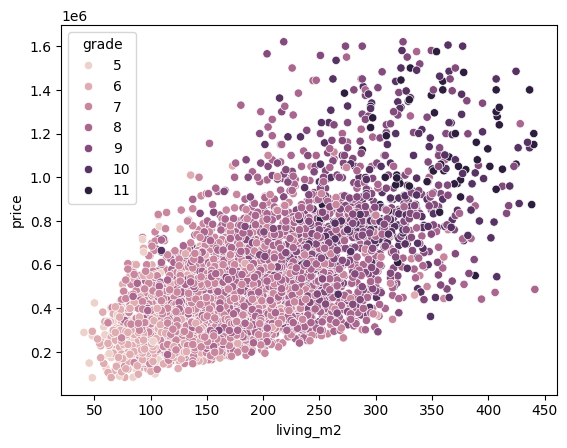

In [43]:
# the grade affects the price greatly, especially when paired with the living area
sns.scatterplot(x="living_m2", y="price", hue="grade", data=df_sample)

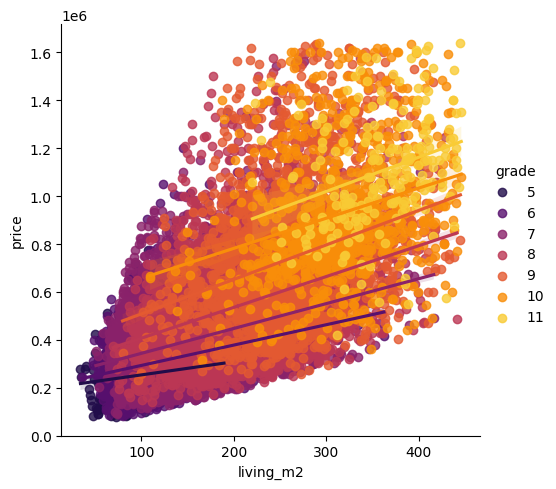

In [44]:
# using regression plot emphasizes the fact: grade + living area affects the price greatly
sns.lmplot(x="living_m2", y="price", hue="grade", data=df, palette="inferno")

C:\Users\tuomas.valtanen\AppData\Local\Temp\ipykernel_13300\2884399613.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="bathrooms", y="price", data=df_sample, palette="magma")


<Axes: xlabel='bathrooms', ylabel='price'>

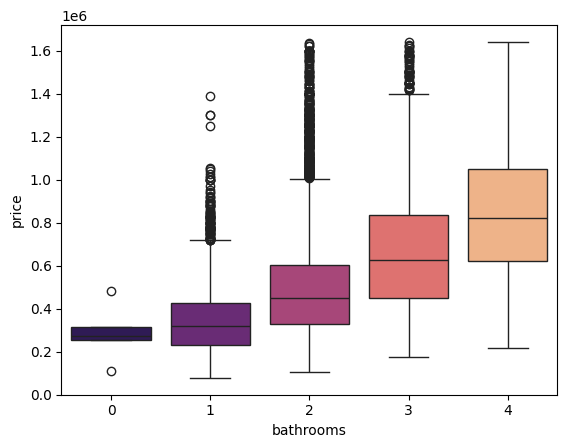

In [45]:
# bathrooms also seem to correlate with higher price
# although, some noise in the data, it seems
df_sample = df.sample(20000)
df_sample['bathrooms'] = df_sample['bathrooms'].round(0).astype(int)

sns.boxplot(x="bathrooms", y="price", data=df_sample, palette="magma")

C:\Users\tuomas.valtanen\AppData\Local\Temp\ipykernel_13300\2747607628.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="bedrooms", y="price", data=df_sample, palette="magma")


<Axes: xlabel='bedrooms', ylabel='price'>

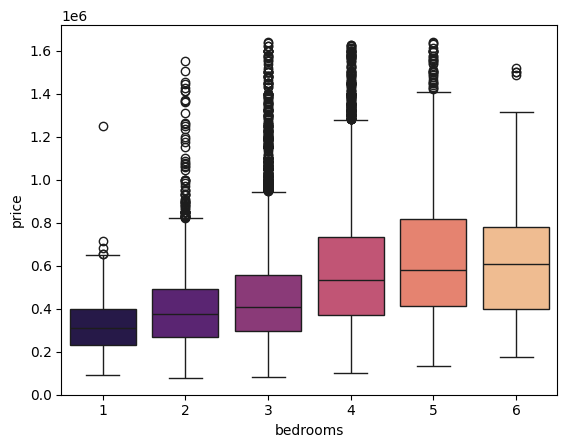

In [ ]:
df_sample = df.sample(20000)
df_sample['bedrooms'] = df_sample['bedrooms'].round(0).astype(int)

# bedrooms have a connection too, but it's not as clear as with the bathrooms
sns.boxplot(x="bedrooms", y="price", data=df_sample, palette="magma")

<h3><b>Results and summary:</b></h3>

The price of a building (based on this dataset) seems to be mostly based on the grade, living square meters and number of bathrooms. The age of the building doesn't affect the price directly, but it affects the living square meters (newer houses are often bigger). Surprisingly the amount of bedrooms affect the price less than the bathrooms (but this probably a feature in US house market).

<h3><b>Ideas for further improvements:</b></h3>

It would be interesting to compare the findings with other housing datasets in other parts of US (do the trends align?). Also comparing to European house market would be interesting.

One idea would also to be processing location data into more usable information, like categories or major area names (implying certain parts of the city tend to increase the price, like city centre).

Also, the data is pretty limited to only year of data (2014-2015.)